In [1]:
import re
import os
import torch
import shutil
import pymupdf4llm

import numpy as np
import pandas as pd

from typing import Optional, List

from langchain_community.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader, TextLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter

from langchain_core.retrievers import BaseRetriever
from langchain.schema import Document
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from rank_bm25 import BM25Okapi

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.messages import stream_response 

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

# Config

In [3]:
## PATH ##
ROOT = os.path.join(os.path.dirname(os.getcwd()), 'AgenticRAGWithFDC')
FILE_PATH = os.path.join(ROOT, "database", "manual")

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}") # 파일이 없을 경우 에러 발생
    
# vector store path
VECTORSTORE_PATH = os.path.join(ROOT, "database/vectorstore")
if not os.path.exists(VECTORSTORE_PATH):
    os.makedirs(VECTORSTORE_PATH)
    
# embedding model path
EMBEDDING_MODEL_DIR_PATH = os.path.join(ROOT, "database/embedding_model/")
if not os.path.exists(EMBEDDING_MODEL_DIR_PATH):
    os.makedirs(EMBEDDING_MODEL_DIR_PATH)

# fdc database path
FDC_DB_PATH = os.path.join(ROOT, "data")
if not os.path.exists(FDC_DB_PATH):
    os.makedirs(FDC_DB_PATH)

# Data Load

In [4]:
anomaly_data = pd.read_csv(os.path.join(FDC_DB_PATH, "anomaly_history_data.csv"))
anomaly_data.head()

,start_time,end_time,p_error,pattern,cmk,threshold,pattern_name
0,2025-04-21 00:05:00,2025-04-21 00:05:59,[[ 0.0551207 0.05511902 0.05635656 0.04391...,[[ 0.00000000e+00 -5.41823433e-07 4.00591580e...,1.776238,2.8,noise
1,2025-04-21 00:06:00,2025-04-21 00:06:59,[[ 0.08541884 0.08540962 0.07238646 0.08685...,[[ 0.00000000e+00 -2.49485145e-06 -3.52460204e...,2.059372,2.8,noise
2,2025-04-21 00:18:00,2025-04-21 00:18:59,[[ 6.57345133e-02 6.57258708e-02 1.75322494e...,[[ 0.00000000e+00 -2.79071990e-06 5.94080097e...,2.761220,2.8,noise
3,2025-04-21 00:31:00,2025-04-21 00:31:59,[[-0.03035255 -0.01160169 -0.01540582 -0.03096...,[[ 0. 0.00542916 0.00432709 ... -0.0...,2.079087,2.8,noise
4,2025-04-21 00:32:00,2025-04-21 00:32:59,[[ 0.0673612 0.06736828 -1.64502691 -0.97818...,[[ 0.00000000e+00 1.98646740e-06 -4.97290366e...,2.624173,2.8,noise


In [5]:
raw_data = pd.read_csv(os.path.join(FDC_DB_PATH, "raw_data.csv"))
raw_data.head()

,TIME,SLOT,STEP_ID,Header_pressure_Act,Header_pressure_Set,state,class,cmk,section_class,error
0,2025-04-21 00:00:00,2.0,1.0,0.998119,0.999861,1,0,NaN,NaN,0.000000
1,2025-04-21 00:00:01,2.0,1.0,0.805644,0.399578,1,0,NaN,NaN,0.000000
2,2025-04-21 00:00:02,2.0,1.0,0.407863,0.399578,1,0,NaN,NaN,0.000003
3,2025-04-21 00:00:03,2.0,2.0,0.675494,0.999861,1,0,NaN,NaN,0.000000
4,2025-04-21 00:00:04,2.0,2.0,1.008201,0.999861,1,0,NaN,NaN,0.000003


In [6]:
from langchain_community.document_loaders import Docx2txtLoader

loader = Docx2txtLoader("./database/manual/조치이력보고서.docx")
docs = loader.load()
print(len(docs))

1


In [7]:
for doc in docs:
    print(doc.page_content)

보고서



문서 번호: RPT-20250421-001

작성 일자: 2025-04-21

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 ‘noise’ 이고 threshold 와 cmk 값의 차가 0.5 미만입니다.

이에 따라 정상 오차 범위로 판단하여 설비 멈춤 없이 공정 진행하였고, 모니터링을 강화 조치를 취했습니다.



오류 2:

감지한 이상 패턴이 'noise'이며, 연속 2회 이상 발생했습니다.

이에 따라 공정 변수를 점검하고 주요 센서를 캘리브레이션 진행 후 정상화를 확인하는 조치를 진행하였습니다.




보고서



문서 번호: RPT-20250422-001

작성 일자: 2025-04-22

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 'drift'로, cmk 값이 0.2 이하입니다.

이에 따라 주요 부품 마모 확인 후 교체를 진행하였으며, 이 후 공정 안정성 재점검을 실시하였습니다.



오류 2:

감지한 이상 패턴이 'drift'이나, cmk가 0.2 이상의 이상이 발생하였습니다.

이에 따라 설비 가동을 유지한 채 해당 구간에 대해 공정 조건 일시 조정 및 경향성을 모니터링 하였습니다. 




보고서



문서 번호: RPT-20250423-001

작성 일자: 2025-04-23

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.

이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다.



오류 2:

감지한 이상 패턴이 'shift'이나, cmk 값이 0.5 이하, 0.4 이상인 이상이 발생하였습니다.

이에 공정 운전은 유지하고, 주기적 측정 강화 및 예비 점검 항목을 추가하였습니다.



오류 3:

감지한 이상 패턴이 ‘shift’로, cmk 값이 0.5 이상인 이상이 발생하였습니다.

이는 공정에 큰 영향을 미치지 않는 이상으로 설비 가동을 유지하였고

# ToolKit

## Retriever: "조치이력보고서"

### Load and Split

In [8]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document
import re

# 1. 워드 파일 로드
loader = Docx2txtLoader("./database/manual/조치이력보고서.docx")
docs = loader.load()

# 2. 전체 텍스트 합치기
full_text = "\n".join([doc.page_content for doc in docs])

# 3. '보고서' 기준으로 페이지 분할
pages = full_text.split("보고서")
pages = [page.strip() for page in pages if page.strip()]

# 최종 저장할 리스트
final_documents = []

# 4. 각 페이지 처리
for page in pages:
    # 문서 번호, 작성 일자, 작성자 추출
    doc_num_match = re.search(r"문서 번호:\s*(.+)", page)
    date_match = re.search(r"작성 일자:\s*(.+)", page)
    writer_match = re.search(r"작성자:\s*(.+)", page)
    
    doc_num = doc_num_match.group(1).strip() if doc_num_match else ""
    date = date_match.group(1).strip() if date_match else ""
    writer = writer_match.group(1).strip() if writer_match else ""
    
    # '조치 이력' 이후만 잘라서 오류 파싱
    after_history = page.split("[조치 이력]")[-1].strip()
    
    # "오류 1:", "오류 2:" 기준으로 오류 분리
    errors = re.split(r"오류\s*\d+\s*:", after_history)
    errors = [e.strip() for e in errors if e.strip()]
    
    # 오류 번호도 필요하니까 다시 찾자
    error_numbers = re.findall(r"오류\s*(\d+)\s*:", after_history)

    for error_content, error_no in zip(errors, error_numbers):
        document = Document(
            page_content=error_content,
            metadata={
                "문서 번호": doc_num,
                "작성 일자": date,
                "작성자": writer,
                "오류번호": int(error_no)
            }
        )
        final_documents.append(document)

# 5. 결과 확인
for i, doc in enumerate(final_documents):
    print(f"[Document {i+1}]")
    print(doc.metadata)
    print(doc.page_content)
    print("\n")


[Document 1]
{'문서 번호': 'RPT-20250421-001', '작성 일자': '2025-04-21', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 ‘noise’ 이고 threshold 와 cmk 값의 차가 0.5 미만입니다.

이에 따라 정상 오차 범위로 판단하여 설비 멈춤 없이 공정 진행하였고, 모니터링을 강화 조치를 취했습니다.


[Document 2]
{'문서 번호': 'RPT-20250421-001', '작성 일자': '2025-04-21', '작성자': '김프로', '오류번호': 2}
감지한 이상 패턴이 'noise'이며, 연속 2회 이상 발생했습니다.

이에 따라 공정 변수를 점검하고 주요 센서를 캘리브레이션 진행 후 정상화를 확인하는 조치를 진행하였습니다.


[Document 3]
{'문서 번호': 'RPT-20250422-001', '작성 일자': '2025-04-22', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 'drift'로, cmk 값이 0.2 이하입니다.

이에 따라 주요 부품 마모 확인 후 교체를 진행하였으며, 이 후 공정 안정성 재점검을 실시하였습니다.


[Document 4]
{'문서 번호': 'RPT-20250422-001', '작성 일자': '2025-04-22', '작성자': '김프로', '오류번호': 2}
감지한 이상 패턴이 'drift'이나, cmk가 0.2 이상의 이상이 발생하였습니다.

이에 따라 설비 가동을 유지한 채 해당 구간에 대해 공정 조건 일시 조정 및 경향성을 모니터링 하였습니다.


[Document 5]
{'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.

이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다.


[Document 6]
{

### Retrieval

In [9]:
os.environ["TRANSFORMERS_CACHE"] = EMBEDDING_MODEL_DIR_PATH
os.environ["HF_HOME"] = EMBEDDING_MODEL_DIR_PATH

In [10]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name = "intfloat/multilingual-e5-large-instruct",
)

vectorstore = FAISS.from_documents(
    final_documents,
    embedding_model,
)

retriever = vectorstore.as_retriever()

c:\Users\kangd\anaconda3\envs\rag\Lib\site-packages\transformers\utils\hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [11]:
retriever.invoke("이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?")

[Document(id='d6e7f9d2-c7e6-4499-a5f9-cb5c1a77a9e1', metadata={'문서 번호': 'RPT-20250425-001', '작성 일자': '2025-04-25', '작성자': '장프로', '오류번호': 1}, page_content="감지한 이상 패턴이 'quantize'로, 데이터가 특정값에 몰리는 현상이 발생하였습니다.\n\n이에 따라 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고하였습니다."),
 Document(id='1801665d-ffa2-46d1-a050-1f5663301de2', metadata={'문서 번호': 'RPT-20250425-001', '작성 일자': '2025-04-25', '작성자': '장프로', '오류번호': 2}, page_content='감지한 이상 패턴이 ‘quantize’로, 같은 이상이 같은 날 4건 이상 발생하였습니다.\n\n이에 따라 센서 이상 또는 데이터 전송 간 노이즈 가능성이 확인되었습니다. 센서를 교체하고 데이터 수집 시스템을 점검하였습니다.'),
 Document(id='fb256221-289b-4be0-8c82-a136df3ce56f', metadata={'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 4}, page_content='감지한 이상 패턴이 ‘shift’로, cmk값이 0.5 이하이고, 같은 날 동일한 패턴의 이상이 5건 이상 발생되었습니다.\n\n이에 설비 가동을 중지하고, 설비 정비 부서에 연락 및 팀장에게 보고하였습니다.\n\n(* 설비 정비 부서 연락처: 123-4567)'),
 Document(id='fc1ebcf6-f429-44df-9e05-7f00b025c8d0', metadata={'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 2}, page_conte

## Retrieval: 발생 이상 패턴 정보

In [12]:
def row_to_text(row):
    return (
        f"Start Time: {row['start_time']}, End Time: {row['end_time']}, "
        f"Pattern: {row['pattern_name']}, CMK: {row['cmk']}, Threshold: {row['threshold']}"
    )
anomaly_data = pd.read_csv(os.path.join(FDC_DB_PATH, "anomaly_history_data.csv"))
anomaly_data['content'] = anomaly_data.apply(row_to_text, axis=1)

# 3. 문서화
docs = [Document(page_content=text) for text in anomaly_data['content']]

# 4. 벡터화 및 저장
embedding_model = HuggingFaceEmbeddings(
    model_name = "intfloat/multilingual-e5-large-instruct",
)
vectorstore_anomaly_info = FAISS.from_documents(docs, embedding_model)
retriever_anomaly_info = vectorstore_anomaly_info.as_retriever(search_kwargs={"k": 5})

In [13]:
docs

[Document(metadata={}, page_content='Start Time: 2025-04-21 00:05:00, End Time: 2025-04-21 00:05:59, Pattern: noise, CMK: 1.7762380326423548, Threshold: 2.8'),
 Document(metadata={}, page_content='Start Time: 2025-04-21 00:06:00, End Time: 2025-04-21 00:06:59, Pattern: noise, CMK: 2.059371735606184, Threshold: 2.8'),
 Document(metadata={}, page_content='Start Time: 2025-04-21 00:18:00, End Time: 2025-04-21 00:18:59, Pattern: noise, CMK: 2.761219835360997, Threshold: 2.8'),
 Document(metadata={}, page_content='Start Time: 2025-04-21 00:31:00, End Time: 2025-04-21 00:31:59, Pattern: noise, CMK: 2.079087081343181, Threshold: 2.8'),
 Document(metadata={}, page_content='Start Time: 2025-04-21 00:32:00, End Time: 2025-04-21 00:32:59, Pattern: noise, CMK: 2.62417273120277, Threshold: 2.8'),
 Document(metadata={}, page_content='Start Time: 2025-04-22 00:06:00, End Time: 2025-04-22 00:06:59, Pattern: drift, CMK: 2.9691635408779016, Threshold: 4.0'),
 Document(metadata={}, page_content='Start Ti

## FDC Retriever

In [14]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI

date_extraction_prompt = PromptTemplate.from_template("""
Extract the start and end date from the user's request below.

Respond in JSON format like:
{{
  "start_time": "YYYY-MM-DD",
  "end_time": "YYYY-MM-DD"
}}

User Request: {input}
""")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)
date_extraction_chain = LLMChain(llm=llm, prompt=date_extraction_prompt)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8132\4127815082.py:18: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  date_extraction_chain = LLMChain(llm=llm, prompt=date_extraction_prompt)


In [15]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI

column_and_date_prompt = PromptTemplate(
    input_variables=["query", "chat_history", "today", "latest_data_date"],
    template="""
From the user's query and chat history below, extract:

1. "columns": A list of column names to visualize. Use only from:
   - Header_pressure_Act
   - Header_pressure_Set
   - cmk
   - error

2. "start_time" and "end_time": Extract in 'YYYY-MM-DD' format.
   - If **no date is given**, use the most recent available date: {latest_data_date}.
   - If the user says things like "위 그래프", "이전 결과", "앞에서 본", extract the date from the **most recent assistant response in chat_history** that includes "시각화한 날짜: YYYY-MM-DD".

3. "message": A short reasoning (e.g., "사용자가 날짜를 명시하지 않았기 때문에 가장 최근 저장일을 사용함").

Feature Mapping Rules:
- "설정값", "setpoint", "target" → Header_pressure_Set
- "실제값", "actual", "measured" → Header_pressure_Act
- "에러", "error", "이상", "비정상" → error
- "공정능력", "cmk", "품질지수" → cmk

Use only column names above. Return as strict JSON like:
{{
  "columns": ["error"],
  "start_time": "2025-04-25",
  "end_time": "2025-04-25",
  "message": "사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함"
}}

User Query: {query}

Chat History:
{chat_history}
"""
)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)
column_and_date_chain = LLMChain(llm=llm, prompt=column_and_date_prompt)

In [16]:
from typing import List, Optional
from langchain.tools import tool
from langchain.agents import AgentExecutor, initialize_agent, Tool
from langchain.agents.agent_types import AgentType
from langchain.llms import OpenAI  # 또는 원하는 LLM
from langchain_core.documents import Document

import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
import json
from docx import Document as DocxDocument
import re

from IPython.display import display, HTML

last_anomaly_row = None

# Tool 1: Plot sequence column
# @tool("plot_sensor_data", return_direct=False)
def plot_sensor_data(columns: List[str], query:str, start_time=None, end_time=None) -> str:

    # Load the data
    df = raw_data.copy()
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    if start_time:
        df = df[df['TIME'] >= pd.to_datetime(start_time)]
    if end_time:
        df = df[df['TIME'] <= pd.to_datetime(end_time)]
       
    fig, ax = plt.subplots(figsize=(12, 4))
    for col in columns:
        ax.plot(df['TIME'], df[col], label=col)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title("Sensor Data: {', '.join(columns)}")
    ax.legend()
    ax.grid()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_base64}" />'
    
def plot_sensor_data_with_llm(query: str, chat_history=None) -> str:
    # 날짜 추출
    latest_data_date = pd.to_datetime(raw_data['TIME']).max().strftime("%Y-%m-%d")
    today = pd.to_datetime("today").strftime("%Y-%m-%d")

    # chat_history가 메시지 리스트라면 문자열로 변환
    if isinstance(chat_history, list):
        chat_history = "\n".join([m.content for m in chat_history if hasattr(m, "content")])
    if chat_history is None:
        chat_history = ""

    print(f"[DEBUG] query: {query}")
    print(f"[DEBUG] today: {today}, latest_data_date: {latest_data_date}")
    print(f"[DEBUG] chat_history: {chat_history}")

    # LLM 프롬프트 실행
    try:
        result_raw = column_and_date_chain.run({
            "query": query,
            "chat_history": chat_history,
            "today": today,
            "latest_data_date": latest_data_date
        })
    except Exception as e:
        print(f"[ERROR] column_and_date_chain execution failed: {e}")
        return "[ERROR] LLM 체인 실행 실패"

    print(f"[DEBUG] LLM raw result:\n{result_raw}")

    # JSON 추출 및 파싱
    json_str = re.sub(r"^```(?:json)?\s*|\s*```$", "", result_raw.strip(), flags=re.MULTILINE)
    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"[ERROR] JSON decoding failed: {e}")
        return "[ERROR] LLM 응답을 JSON으로 파싱하지 못했습니다."

    print(f"[DEBUG] Parsed result: {parsed}")

    columns = parsed.get("columns", [])
    start_time = parsed.get("start_time")
    end_time = parsed.get("end_time")
    message = parsed.get("message", "")

    print(f"[DEBUG] columns: {columns}")
    print(f"[DEBUG] start_time: {start_time}, end_time: {end_time}")
    print(f"[DEBUG] message: {message}")

    def normalize_date(date_str: Optional[str], is_start: bool):
        if date_str and len(date_str) == 10:
            return f"{date_str} 00:00:00" if is_start else f"{date_str} 23:59:59"
        return date_str

    start_time = normalize_date(start_time, is_start=True)
    end_time = normalize_date(end_time, is_start=False)

    print(f"[DEBUG] Normalized start_time: {start_time}")
    print(f"[DEBUG] Normalized end_time: {end_time}")

    chart = plot_sensor_data(columns, query, start_time, end_time)

    if chart:
        visual_date = start_time[:10] if start_time else "알 수 없음"
        result = f"{message}<br>시각화한 날짜: {visual_date}<br>{chart}"
    else:
        result = "[그래프 생성 실패]"

    print(f"[DEBUG] Final return string (truncated): {result[:200]}...")
    return result



# # Tool 2: Viz anomaly pattern
# def show_anomaly_pattern_with_llm(query: str) -> str:
#     # 1. 날짜 정보 추출
#     result_raw = column_and_date_chain.run({"query": query})
#     json_str = re.sub(r"^```(?:json)?\s*|\s*```$", "", result_raw.strip(), flags=re.MULTILINE)
#     parsed = json.loads(json_str)
    
#     start_time = parsed.get("start_time")
#     end_time = parsed.get("end_time")
#     message = parsed.get("message", "")

#     # 2. 날짜만 들어온 경우 시간 보정
#     def normalize_date(date_str: Optional[str], is_start: bool):
#         if date_str and len(date_str) == 10:
#             return f"{date_str} 00:00:00" if is_start else f"{date_str} 23:59:59"
#         return date_str

#     start_time = pd.to_datetime(normalize_date(start_time, is_start=True))
#     end_time = pd.to_datetime(normalize_date(end_time, is_start=False))

#     # 3. anomaly_data에서 해당 날짜에 맞는 row 찾기
#     df = anomaly_data.copy()
#     df["start_time"] = pd.to_datetime(df["start_time"])
#     df["end_time"] = pd.to_datetime(df["end_time"])

#     match = df[(df["start_time"] <= end_time) & (df["end_time"] >= start_time)]

#     if match.empty:
#         return message + "<br>해당 시간대의 이상 패턴이 존재하지 않습니다."

#     row = match.iloc[0]
#     pattern = eval(row["pattern"])
#     plt.imshow([pattern], cmap="gray", aspect="auto")
#     plt.title(f"Pattern: {row['pattern_name']} ({row['start_time']} ~ {row['end_time']})")

#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     plt.close()
#     buf.seek(0)

#     global last_anomaly_row
#     last_anomaly_row = row

#     img_base64 = base64.b64encode(buf.read()).decode("utf-8")
#     return message + "<br>" + f'<img src="data:image/png;base64,{img_base64}" />'

## Tool

In [17]:
tools = [
    Tool(
        name="PlotSensorDataWithLLM",
        description=(
            "Use this tool to plot raw or derived sensor values (e.g., setpoint, actual, CMK, or error) over time. "
            "The data comes from full time-series logs, not from anomaly detection results. "
            "Trigger this tool when the user asks to see trends, behaviors, or differences across sensor features such as "
            "'설정값', '실제값', '공정능력', 'error 그래프', '시계열 그래프', etc.\n\n"
            "**Use this when the user is asking about raw measurement trends or model error curves over time.**"
        ),
        func=plot_sensor_data_with_llm,
        return_direct=True,
    ),
    Tool(
        name="RecomendActions",
        description=(
        "Use this to retrieve recommended actions for an anomaly pattern.\n"
            "If the user asks about a specific pattern (e.g., 'quantize', 'noise', 'shift'), "
            "use this tool directly with the pattern name as input.\n"
            "If the user is referring to a previously retrieved anomaly by index "
            "(e.g., '2nd anomaly from above'), use stored context to fetch cmk, threshold, and pattern_name."
        ),
        func=lambda x: retriever.invoke(x),
    ),
    Tool(
        name="QueryAnomalyHistory",
        description=(
            "Use this tool to answer questions like 'what pattern occurred?', 'what anomalies happened on a certain day?', "
            "or 'which error pattern was found?'.\n\n"
            "This tool returns pattern name, CMK, and threshold for a given date.\n\n"
            "If the user asks about a specific date (e.g., '2025-04-23'), use that date directly.\n\n"
            "If the user asks about a date range (e.g., 'last week', 'last month'), use the most recent date from the conversation.\n\n"
            "If the user asks about a specific anomaly (e.g., '2nd anomaly from above'), use the stored context to fetch the date.\n\n"
            "If the user asks about a specific pattern (e.g., 'quantize'), use that pattern name directly.\n\n"
            "This tool works **based on a specific date or date range**, which can be directly mentioned in the question "
            "(e.g., '2025-04-23', '2025-04-24 ect) or inferred from the conversation.\n\n"
            "If the user asks using implicit references like 'the graph above', 'that time', or 'previous result', "
            "this tool will use the **most recent date used in previous visualizations or answers**.\n\n"
            "**Important:** Be attentive to the date that was used in the previous interaction. This tool always queries anomalies "
            "based on a time window and will fallback to the most recently referenced date if none is explicitly given."
        ),
        func=lambda x: retriever_anomaly_info.invoke(x),
    )
]

# Agent

In [18]:
from langchain.memory import ConversationBufferMemory

import re

class FilteredConversationMemoryWithDateSummary(ConversationBufferMemory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        object.__setattr__(self, "visualization_log", [])  # 필드 강제 추가

    def save_context(self, inputs, outputs, **kwargs):
        filtered_outputs = {}

        for key, val in outputs.items():
            if isinstance(val, str) and "data:image/png;base64" in val:
                summary = "[이미지 출력 생략됨]"
                date_match = re.search(r'20\d{2}-\d{2}-\d{2}', val)
                if date_match:
                    date_str = date_match.group(0)
                    summary += f"\n시각화한 날짜: {date_str}"
                    self.visualization_log.append((len(self.chat_memory.messages), date_str))
                filtered_outputs[key] = summary
            else:
                filtered_outputs[key] = val

        super().save_context(inputs, filtered_outputs, **kwargs)


In [19]:
from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent, AgentType

memory = FilteredConversationMemoryWithDateSummary(memory_key="chat_history", return_messages=True)
agent = initialize_agent(
    tools=tools,
    llm = ChatGoogleGenerativeAI(temperature=0.2, model="gemini-2.0-flash"),
    verbose=True,
    memory=memory,
    agent_type="zero-shot-react-description",
)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8132\1379762183.py:5: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [20]:
agent.invoke("이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?")



> Entering new AgentExecutor chain...
The user is asking about recommended actions for the 'quantize' anomaly pattern.
Action: RecomendActions
Action Input: quantize
Observation: [Document(id='d6e7f9d2-c7e6-4499-a5f9-cb5c1a77a9e1', metadata={'문서 번호': 'RPT-20250425-001', '작성 일자': '2025-04-25', '작성자': '장프로', '오류번호': 1}, page_content="감지한 이상 패턴이 'quantize'로, 데이터가 특정값에 몰리는 현상이 발생하였습니다.\n\n이에 따라 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고하였습니다."), Document(id='1801665d-ffa2-46d1-a050-1f5663301de2', metadata={'문서 번호': 'RPT-20250425-001', '작성 일자': '2025-04-25', '작성자': '장프로', '오류번호': 2}, page_content='감지한 이상 패턴이 ‘quantize’로, 같은 이상이 같은 날 4건 이상 발생하였습니다.\n\n이에 따라 센서 이상 또는 데이터 전송 간 노이즈 가능성이 확인되었습니다. 센서를 교체하고 데이터 수집 시스템을 점검하였습니다.'), Document(id='9d94bf7a-1a5f-4e00-a2fd-a5791dc2a380', metadata={'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 1}, page_content="감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.\n\n이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다."), Document(id='3c4b4

{'input': "이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?",
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={})],
 'output': "'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다."}



> Entering new AgentExecutor chain...
The user is asking about the most recent error graph of the equipment. This implies plotting the error over time.
Action: PlotSensorDataWithLLM
Action Input: error 그래프[DEBUG] query: error 그래프
[DEBUG] today: 2025-05-09, latest_data_date: 2025-04-25
[DEBUG] chat_history: 


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8132\2026196627.py:66: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result_raw = column_and_date_chain.run({


[DEBUG] LLM raw result:
```json
{
  "columns": ["error"],
  "start_time": "2025-04-25",
  "end_time": "2025-04-25",
  "message": "사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함"
}
```
[DEBUG] Parsed result: {'columns': ['error'], 'start_time': '2025-04-25', 'end_time': '2025-04-25', 'message': '사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함'}
[DEBUG] columns: ['error']
[DEBUG] start_time: 2025-04-25, end_time: 2025-04-25
[DEBUG] message: 사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함
[DEBUG] Normalized start_time: 2025-04-25 00:00:00
[DEBUG] Normalized end_time: 2025-04-25 23:59:59
[DEBUG] Final return string (truncated): 사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함<br>시각화한 날짜: 2025-04-25<br><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABLAAAAGQCAYAAAC+tZleAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsI...

Observation: 사용자가 날짜를 명시하지 않아 최신 데이터인 2025-04-25을 사용함<br>시각화한 날짜: 2025-04-25<br>


> Finished chain.

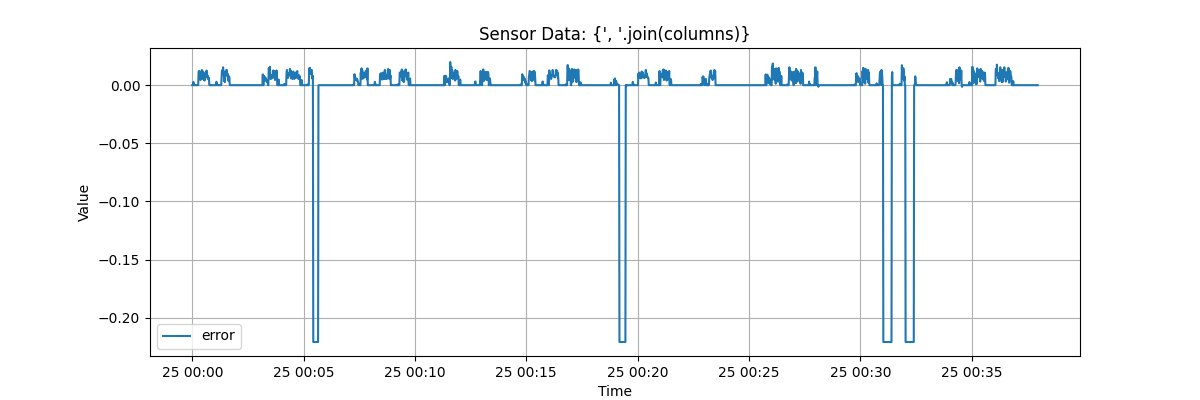


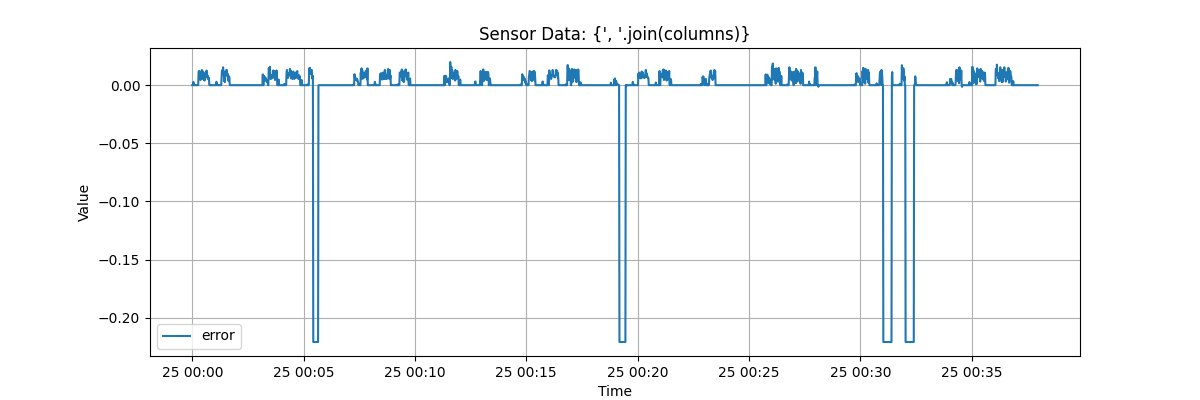

In [21]:
result = agent.invoke("가장 최근 설비의 error 그래프는 어떤가?")
display(HTML(result["output"]))



> Entering new AgentExecutor chain...
The user is asking for a graph of '설정값' and '실제값' on 2025-04-23. This requires plotting sensor data over time.
Action: PlotSensorDataWithLLM
Action Input: 2025-04-23 설정값 실제값 그래프[DEBUG] query: 2025-04-23 설정값 실제값 그래프
[DEBUG] today: 2025-05-09, latest_data_date: 2025-04-25
[DEBUG] chat_history: 
[DEBUG] LLM raw result:
```json
{
  "columns": [
    "Header_pressure_Set",
    "Header_pressure_Act"
  ],
  "start_time": "2025-04-23",
  "end_time": "2025-04-23",
  "message": "사용자가 2025-04-23 날짜를 명시함"
}
```
[DEBUG] Parsed result: {'columns': ['Header_pressure_Set', 'Header_pressure_Act'], 'start_time': '2025-04-23', 'end_time': '2025-04-23', 'message': '사용자가 2025-04-23 날짜를 명시함'}
[DEBUG] columns: ['Header_pressure_Set', 'Header_pressure_Act']
[DEBUG] start_time: 2025-04-23, end_time: 2025-04-23
[DEBUG] message: 사용자가 2025-04-23 날짜를 명시함
[DEBUG] Normalized start_time: 2025-04-23 00:00:00
[DEBUG] Normalized end_time: 2025-04-23 23:59:59
[DEBUG] Final return st
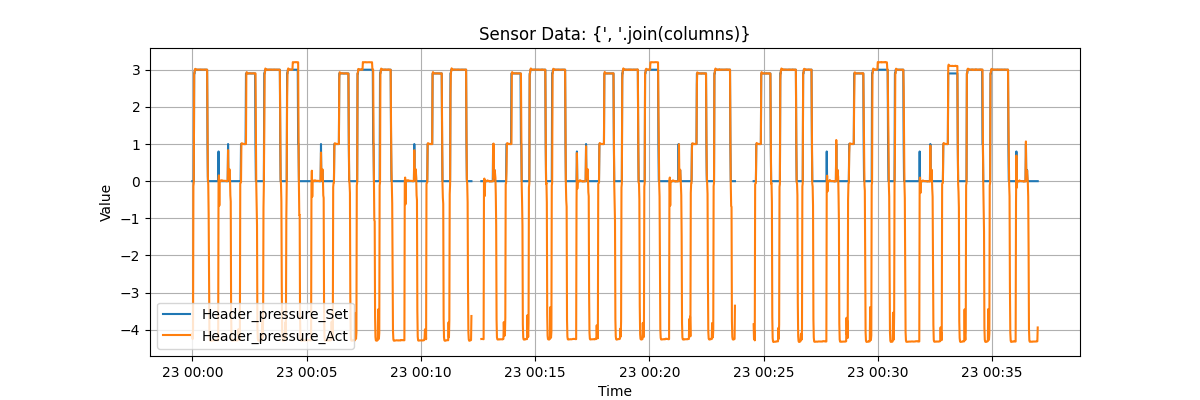


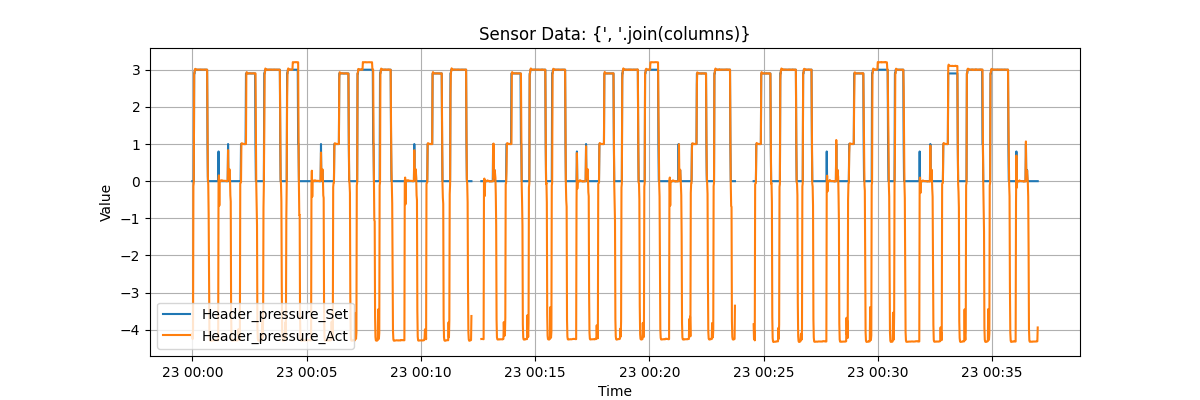

In [22]:
result = agent.invoke("2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?")
display(HTML(result["output"]))

In [23]:
agent.invoke("그렇다면, 위 그래프의 error 패턴은 어떤가?")



> Entering new AgentExecutor chain...
The user is asking about the error pattern of the graph above. Since the user is referring to "the graph above", I need to use the date from the previous interaction. I don't have any information about the previous interaction. I need to ask the user to provide the date.
Action: QueryAnomalyHistory
Action Input: the date of the graph
Observation: [Document(id='9caafcdc-809b-4ba3-a2c6-be7a9fb1621d', metadata={}, page_content='Start Time: 2025-04-22 00:33:00, End Time: 2025-04-22 00:33:59, Pattern: drift, CMK: 0.1661013521448154, Threshold: 4.0'), Document(id='0c36c2ff-800e-48a7-9315-ddf49b3ed625', metadata={}, page_content='Start Time: 2025-04-22 00:07:00, End Time: 2025-04-22 00:07:59, Pattern: drift, CMK: 0.7692792331387196, Threshold: 4.0'), Document(id='861e65cd-1a8d-43ab-892c-614efdb1f575', metadata={}, page_content='Start Time: 2025-04-22 00:19:00, End Time: 2025-04-22 00:19:59, Pattern: drift, CMK: 0.5993105207280096, Threshold: 4.0'), Docu

{'input': '그렇다면, 위 그래프의 error 패턴은 어떤가?',
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='가장 최근 설비의 error 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-25', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-23', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='그렇다면, 위 그래프의 error 패턴은 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The error patterns found on 2025-04-22 include 'drift' and on 2025-04-23 include 'shift'.", addit

In [24]:
agent.invoke("2025-04-23에는 어떤 이상 패턴이 있었는가?")



> Entering new AgentExecutor chain...
The user is asking about anomaly patterns on a specific date. I should use the QueryAnomalyHistory tool to find the patterns.
Action: QueryAnomalyHistory
Action Input: 2025-04-23
Observation: [Document(id='f03ebdf6-6d63-4f2a-b5e6-d2667e3456c6', metadata={}, page_content='Start Time: 2025-04-23 00:20:00, End Time: 2025-04-23 00:20:59, Pattern: shift, CMK: 0.4452949050919752, Threshold: 2.8'), Document(id='d9eb0eaf-b17a-4e51-bb9f-62b0b01def66', metadata={}, page_content='Start Time: 2025-04-23 00:30:00, End Time: 2025-04-23 00:30:59, Pattern: shift, CMK: 0.4144710513328189, Threshold: 2.8'), Document(id='2e44650e-63f7-43da-a947-7deb148bb25b', metadata={}, page_content='Start Time: 2025-04-23 00:33:00, End Time: 2025-04-23 00:33:59, Pattern: shift, CMK: 0.4103951705515488, Threshold: 2.8'), Document(id='dbb27a58-167f-4d36-80fa-78d0cd20a28d', metadata={}, page_content='Start Time: 2025-04-23 00:04:00, End Time: 2025-04-23 00:04:59, Pattern: shift, CM

{'input': '2025-04-23에는 어떤 이상 패턴이 있었는가?',
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='가장 최근 설비의 error 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-25', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-23', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='그렇다면, 위 그래프의 error 패턴은 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The error patterns found on 2025-04-22 include 'drift' and on 2025-04-23 include 'shift'.", addi

In [25]:
agent.invoke("2025-04-25에는 어떤 이상 패턴이 있었는가?")



> Entering new AgentExecutor chain...
The user is asking about anomaly patterns on a specific date. I should use the QueryAnomalyHistory tool to find the patterns.
Action: QueryAnomalyHistory
Action Input: 2025-04-25
Observation: [Document(id='bac738f5-4789-4e63-82ec-e9d18774f15e', metadata={}, page_content='Start Time: 2025-04-25 00:05:00, End Time: 2025-04-25 00:05:59, Pattern: quantize, CMK: 0.5255205160567197, Threshold: 2.8'), Document(id='f03ebdf6-6d63-4f2a-b5e6-d2667e3456c6', metadata={}, page_content='Start Time: 2025-04-23 00:20:00, End Time: 2025-04-23 00:20:59, Pattern: shift, CMK: 0.4452949050919752, Threshold: 2.8'), Document(id='d9eb0eaf-b17a-4e51-bb9f-62b0b01def66', metadata={}, page_content='Start Time: 2025-04-23 00:30:00, End Time: 2025-04-23 00:30:59, Pattern: shift, CMK: 0.4144710513328189, Threshold: 2.8'), Document(id='b712d730-82aa-43d3-845d-cfd21405100d', metadata={}, page_content='Start Time: 2025-04-25 00:19:00, End Time: 2025-04-25 00:19:59, Pattern: quanti

{'input': '2025-04-25에는 어떤 이상 패턴이 있었는가?',
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='가장 최근 설비의 error 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-25', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-23', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='그렇다면, 위 그래프의 error 패턴은 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The error patterns found on 2025-04-22 include 'drift' and on 2025-04-23 include 'shift'.", addi

In [26]:
agent.invoke("그러한 이상 패턴이 발생했을 때의 조치사항은 무엇이 있는가?")



> Entering new AgentExecutor chain...
The user is asking about recommended actions for an anomaly pattern, but doesn't specify which one. I need to use the context to determine which anomaly pattern the user is referring to. Since there is no context, I will ask the user to specify the anomaly pattern.
Action: RecomendActions
Action Input: x
Observation: [Document(id='9d94bf7a-1a5f-4e00-a2fd-a5791dc2a380', metadata={'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 1}, page_content="감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.\n\n이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다."), Document(id='3c4b46c4-5867-4af3-bf9e-f2c5cb6643b0', metadata={'문서 번호': 'RPT-20250424-001', '작성 일자': '2025-04-24', '작성자': '장프로', '오류번호': 1}, page_content="감지한 이상 패턴이 'shift'로, cmk 값이 0.8 이하의 이상이 발생하였습니다.\n\n이에 따라 해당 설비의 순간 부하 또는 외부 간섭이 의심되어, 주요 케이블 연결 상태를 점검 및 데이터 필터링을 적용하였습니다."), Document(id='c6304dab-638b-4818-964e-c5d01964e266', metadata={'문서 번호': 'RPT-20250424-001', '작성 일자': '

{'input': '그러한 이상 패턴이 발생했을 때의 조치사항은 무엇이 있는가?',
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='가장 최근 설비의 error 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-25', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-23', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='그렇다면, 위 그래프의 error 패턴은 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The error patterns found on 2025-04-22 include 'drift' and on 2025-04-23 include 'shift'.",

In [27]:
agent.invoke("그 때의 cmk는 얼마인가?")



> Entering new AgentExecutor chain...
The question is asking about the CMK value at a specific time. Since the user is using the phrase "그 때" (that time), I need to refer to the most recent date or time mentioned in the conversation. I don't have access to the conversation history, so I will need to ask the user to provide the date for which they are asking about the CMK value.
Action: QueryAnomalyHistory
Action Input: Need a specific date to find the CMK value. Can you please provide the date?
Observation: [Document(id='919b59af-4681-42e5-b7eb-fff55d4d12a8', metadata={}, page_content='Start Time: 2025-04-24 00:31:00, End Time: 2025-04-24 00:31:59, Pattern: spike, CMK: 1.2241977030293596, Threshold: 2.8'), Document(id='08b78504-b0b1-4c2f-8077-2c1d16f99c40', metadata={}, page_content='Start Time: 2025-04-24 00:17:00, End Time: 2025-04-24 00:17:59, Pattern: spike, CMK: 0.8761632580304209, Threshold: 2.8'), Document(id='410e8378-e448-475c-a4e4-387cc6df0bcd', metadata={}, page_content='S

{'input': '그 때의 cmk는 얼마인가?',
 'chat_history': [HumanMessage(content="이상 패턴이 'quantize' 인 경우 어떤 조치들이 있는가?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="'quantize' 이상 패턴에 대한 조치로는 다음이 있습니다. 1) 공정 운전은 유지하되, 주기적으로 측정을 강화하고 팀장에게 보고합니다. 2) 센서 이상 또는 데이터 전송 간 노이즈 가능성을 확인하고, 센서를 교체하고 데이터 수집 시스템을 점검합니다.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='가장 최근 설비의 error 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-25', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='2025-04-23의 설비의 설정값과 실제값의 그래프는 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[이미지 출력 생략됨]\n시각화한 날짜: 2025-04-23', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='그렇다면, 위 그래프의 error 패턴은 어떤가?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The error patterns found on 2025-04-22 include 'drift' and on 2025-04-23 include 'shift'.", additional_kwargs